# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

2024-10-20 22:11:57.906909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date
data.set_index("Date", inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Date'>

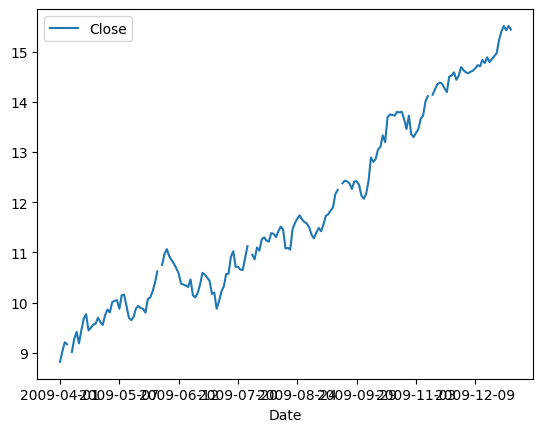

In [5]:
# Plot the Close Data
data.plot(y="Close")

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
# Check for null values
print('Number of Null Values =', data.isnull().sum())

Number of Null Values = Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64


In [7]:
# forward fill missing values
data=data.ffill()
display_df(data)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-07,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0


In [8]:
# Check for null values
print('Number of Null Values =', data.isnull().sum())

Number of Null Values = Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<Axes: xlabel='Date'>

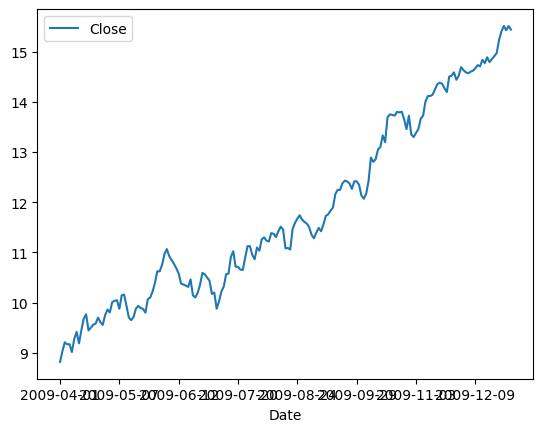

In [9]:
# Plot the cleaned Close Data
data.plot(y="Close")

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [10]:
# Calculate 20-day bollinger bands
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()
data['BB_upper'] = data['MA20'] + (data['STD20'] * 2)
data['BB_lower'] = data['MA20'] - (data['STD20'] * 2)
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data['Vol20'] = data['Log_Ret'].rolling(window=20).std() * np.sqrt(252)
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,STD20,BB_upper,BB_lower,Log_Ret,Vol20
Date,,,,,,,,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0,NaN,NaN,NaN,NaN,NaN,0.023473,NaN
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0,NaN,NaN,NaN,NaN,NaN,0.019884,NaN
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0,NaN,NaN,NaN,NaN,NaN,-0.004173,NaN
2009-04-07,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0,9.080215,NaN,NaN,NaN,NaN,0.000000,NaN
2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0,9.119618,NaN,NaN,NaN,NaN,-0.017091,NaN
2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0,9.169431,NaN,NaN,NaN,NaN,0.028593,NaN
2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0,9.210925,NaN,NaN,NaN,NaN,0.014948,NaN
2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0,9.214263,NaN,NaN,NaN,NaN,-0.024632,NaN


In [11]:
# Remove rows with NaN bollinger bands
data = data.dropna(axis=0)
display_df(data)

,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,STD20,BB_upper,BB_lower,Log_Ret,Vol20
Date,,,,,,,,,,,,,
2009-04-30,9.857053,10.056057,9.833143,9.862284,9.862284,174881049.0,9.696605,9.447924,0.254066,9.956057,8.939792,0.011430,0.275989
2009-05-01,9.838871,9.902633,9.752196,9.805497,9.805497,97471985.0,9.717526,9.486766,0.245844,9.978454,8.995079,-0.005775,0.270321
2009-05-04,9.917078,10.022433,9.832894,10.011973,10.011973,128600225.0,9.797377,9.526866,0.263121,10.053107,9.000625,0.020839,0.271079
2009-05-05,9.962159,10.087191,9.894164,10.037128,10.037128,96391952.0,9.893417,9.570141,0.272622,10.115385,9.024898,0.002509,0.269382
2009-05-06,10.131774,10.168885,9.987564,10.049084,10.049084,105710750.0,9.953193,9.614014,0.275700,10.165415,9.062614,0.001190,0.269151
2009-05-07,10.064775,10.086942,9.775858,9.878224,9.878224,120441759.0,9.956381,9.657115,0.242734,10.142584,9.171646,-0.017149,0.269213
2009-05-08,10.033641,10.214962,9.838124,10.145223,10.145223,155183494.0,10.024327,9.700490,0.248804,10.198098,9.202882,0.026670,0.267014
2009-05-11,10.032396,10.261537,9.992545,10.161413,10.161413,102755715.0,10.054214,9.737688,0.259638,10.256965,9.218412,0.001595,0.264257
2009-05-12,10.211973,10.236382,9.840864,9.938000,9.938000,152200354.0,10.034389,9.775173,0.228385,10.231943,9.318403,-0.022232,0.260947


<Axes: xlabel='Date'>

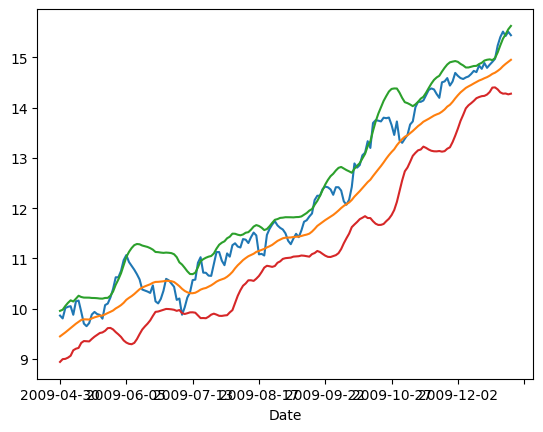

In [12]:
# Plot Features: Close, MA20, BB Upper, BB Lower
data['Close'].plot()
data['MA20'].plot()
data['BB_upper'].plot()
data['BB_lower'].plot()

<Axes: xlabel='Date'>

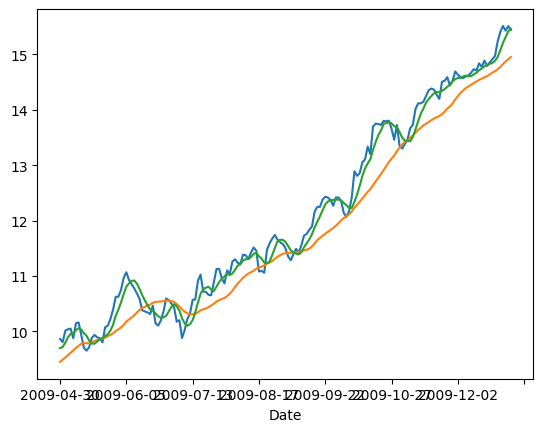

In [13]:
# Plot Features: Close, MA20, MA5
data['Close'].plot()
data['MA20'].plot()
data['MA5'].plot()

<Axes: xlabel='Date'>

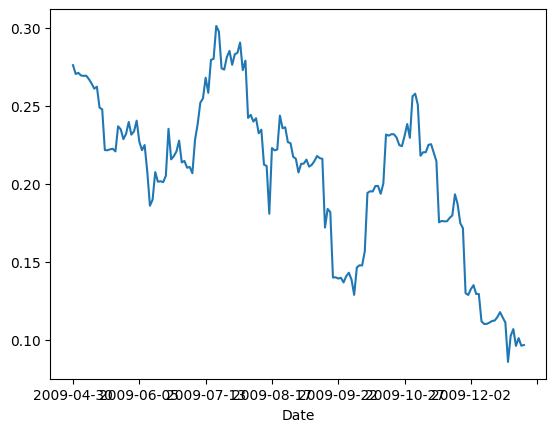

In [14]:
# Plot Features: Volatility
data['Vol20'].plot()

In [15]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[["Close", "BB_upper", "BB_lower"]]
dataset.head()

,Close,BB_upper,BB_lower
Date,,,
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898
2009-05-06,10.049084,10.165415,9.062614


# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

In [16]:
# Display & Plot Un-normalized Dataset
display(dataset)

,Close,BB_upper,BB_lower
Date,,,
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898
2009-05-06,10.049084,10.165415,9.062614
2009-05-07,9.878224,10.142584,9.171646
2009-05-08,10.145223,10.198098,9.202882
2009-05-11,10.161413,10.256965,9.218412
2009-05-12,9.938000,10.231943,9.318403


<Axes: xlabel='Date'>

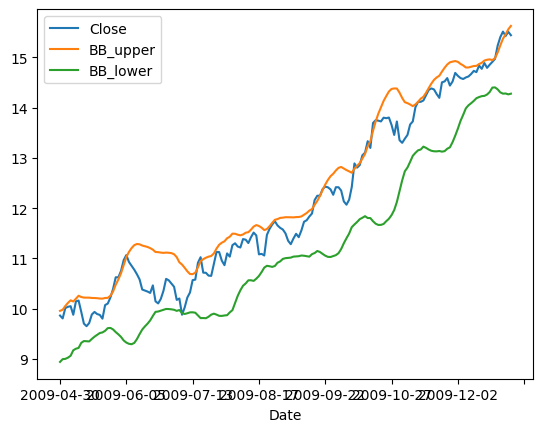

In [17]:
dataset.plot()

In [18]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[col].values.reshape(-1, 1)
    
    # fit normalizer to column data
    normalizer.fit(column_data)
    
    # transform column data with the fitted normalizer, and place the transformed data column in out normed_dataset df
    normalized_data = normalizer.transform(column_data)
    
    # append the fitted normalizer to normlist for use later
    normed_dataset[col] = normalized_data
    normlist.append(normalizer)


In [19]:
# Display & Plot Normalized Dataset
display(normed_dataset)

,Close,BB_upper,BB_lower
Date,,,
2009-04-30,-1.288097,-1.452468,-1.389927
2009-05-01,-1.320912,-1.439029,-1.355674
2009-05-04,-1.201596,-1.394232,-1.352238
2009-05-05,-1.187060,-1.356861,-1.337201
2009-05-06,-1.180152,-1.326839,-1.313834
2009-05-07,-1.278885,-1.340540,-1.246285
2009-05-08,-1.124596,-1.307228,-1.226933
2009-05-11,-1.115240,-1.271903,-1.217312
2009-05-12,-1.244343,-1.286918,-1.155364


<Axes: xlabel='Date'>

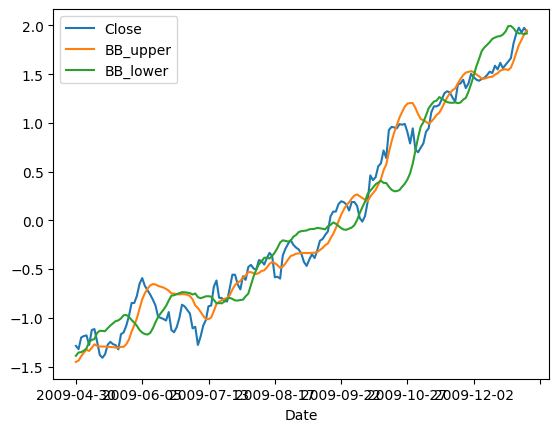

In [20]:
normed_dataset.plot()

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [21]:
# split dataset df into train (50%) and test (50%) datasets

train_df =  normed_dataset.iloc[:int(len(data)*0.5)]# define training dtaframe under this variable name
test_df  =  normed_dataset.iloc[int(len(data)*0.5):]# define testing dtaframe under this variable name

In [22]:
# display train and test dfs (ensure no overlap)

In [23]:
display(train_df)

,Close,BB_upper,BB_lower
Date,,,
2009-04-30,-1.288097,-1.452468,-1.389927
2009-05-01,-1.320912,-1.439029,-1.355674
2009-05-04,-1.201596,-1.394232,-1.352238
2009-05-05,-1.187060,-1.356861,-1.337201
2009-05-06,-1.180152,-1.326839,-1.313834
2009-05-07,-1.278885,-1.340540,-1.246285
2009-05-08,-1.124596,-1.307228,-1.226933
2009-05-11,-1.115240,-1.271903,-1.217312
2009-05-12,-1.244343,-1.286918,-1.155364


In [24]:
display(test_df)

,Close,BB_upper,BB_lower
Date,,,
2009-08-31,-0.342499,-0.334079,-0.110528
2009-09-01,-0.427559,-0.333937,-0.107542
2009-09-02,-0.467139,-0.334821,-0.103744
2009-09-03,-0.402228,-0.336046,-0.091431
2009-09-04,-0.347823,-0.332624,-0.088483
2009-09-08,-0.386396,-0.331689,-0.086348
2009-09-09,-0.309395,-0.324930,-0.077849
2009-09-10,-0.209078,-0.303834,-0.080558
2009-09-11,-0.191807,-0.283968,-0.085853


In [25]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.to_numpy(dtype=float)# define training array under this variable name
X_test = test_df.to_numpy(dtype=float)# define testing array under this variable name
# print the shape of X_train to remind yourself how many examples and features are in the dataset
# track index to remember which feature is which
idx_close = 3 # numerical idx of close data column in array
idx_bb_upper = 1 # numerical idx of BB Upper data column in array
idx_bb_lower = 2 # numerical idx of BB Upper data column in array

In [26]:
X_train.shape

(85, 3)

In [27]:
X_test.shape

(86, 3)

# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [28]:
@keras.saving.register_keras_serializable()
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        # Define model layers in Keras
        self.model = keras.Sequential()
        self.model.add(keras.layers.Dense(64, activation='relu', input_shape=(state_size,)))
        self.model.add(keras.layers.Dense(32, activation='relu'))
        self.model.add(keras.layers.Dense(8, activation='relu'))
        self.model.add(keras.layers.Dense(action_size, activation='linear'))

        # Compile model in Keras
        self.model.compile(
            loss='mse',
            optimizer=keras.optimizers.Adam(learning_rate=0.001)
        )



### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [29]:
import random
import numpy as np
from collections import deque
from tensorflow import keras

class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size
        self.num_features = num_features
        self.state_size = (self.window_size + 1) * self.num_features
        self.action_size = 3  # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.test_mode = test_mode

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    # Deep Q-Network (DQN) model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model

    # DQN Predict (with input reshaping)
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))

    # DQN Fit (with input reshaping)
    def fit_model(self, input_state, target_output):
        return self.model.fit(
            input_state.flatten().reshape(1, self.state_size),
            target_output,
            epochs=1,
            verbose=0
        )

    # Agent Action Selector
    def act(self, state):
        # Choose any action at random (Probability = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            # Select random action
            return random.randrange(self.action_size)
        else:
            # Use model to select action
            q_values = self.get_q_values_for_state(state)
            # Return the action that has the highest Q-value
            return np.argmax(q_values[0])

    # Experience Replay (Learning Function)
    def exp_replay(self, batch_size):
        batch_loss = 0
        # Create a mini-batch of the most recent experiences
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in mini_batch:
            if done:
                optimal_q_for_action = reward
            else:
                optimal_q_for_action = reward + self.gamma * np.amax(
                    self.get_q_values_for_state(next_state)[0]
                )
            target_q_values = self.get_q_values_for_state(state)
            target_q_values[0][action] = optimal_q_for_action
            history = self.fit_model(state, target_q_values)
            batch_loss += history.history['loss'][0]
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return batch_loss


# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [30]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# Returns an n-day state representation ending at time t
def get_state(data, t, n): 
    # data is the dataset of interest which holds the state values (e.g., Close, BB Upper, BB Lower)
    # t is the current time step 
    # n is the size of the training window 

    # First, get the window of the dataset at the current time step
    start = t - n + 1
    if start < 0:
        # For the first few iterations, when there's not enough data, pad with the first data point
        pad = np.repeat([data[0]], -start, axis=0)
        window_data = np.concatenate((pad, data[0:t+1]), axis=0)
    else:
        window_data = data[start:t+1]

    # Apply the sigmoid function to each feature
    res = 1 / (1 + np.exp(-window_data))

    # Return an array holding the n-day sigmoid state representation
    return np.array([res.flatten()])

### Training Loop

In [31]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set

In [32]:
keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

window_size = 1

# Assuming num_features is defined based on your dataset, for example:
num_features = normed_dataset.shape[1]

agent = Agent(window_size=window_size, num_features=num_features) # instatniate the agent using the wndow size and the number of training features

/opt/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Running episode 0/2:   0%|          | 0/84 [00:00<?, ?it/s]

Episode 0, Time 2: Buy at $10.01
Episode 0, Time 4: Sell at $10.05, Profit: $0.04
Episode 0, Time 7: Buy at $10.16
Episode 0, Time 8: Sell at $9.94, Profit: -$0.22
Episode 0, Time 11: Buy at $9.71
Episode 0, Time 13: Buy at $9.93
Episode 0, Time 14: Buy at $9.89
Episode 0, Time 15: Buy at $9.88
Episode 0, Time 17: Sell at $10.07, Profit: $0.36
Episode 0, Time 18: Buy at $10.10
Episode 0, Time 19: Buy at $10.22
Episode 0, Time 20: Sell at $10.39, Profit: $0.46
Episode 0, Time 21: Buy at $10.62
Episode 0, Time 22: Sell at $10.62, Profit: $0.73
Episode 0, Time 23: Sell at $10.75, Profit: $0.88
Episode 0, Time 24: Buy at $10.97
Episode 0, Time 26: Buy at $10.93
Episode 0, Time 27: Sell at $10.85, Profit: $0.75
Episode 0, Time 30: Sell at $10.58, Profit: $0.36
Episode 0, Time 31: Sell at $10.38, Profit: -$0.24
Episode 0, Time 32: Sell at $10.36, Profit: -$0.60
Episode 0, Time 33: Sell at $10.34, Profit: -$0.59
Episode 0, Time 34: Buy at $10.31
Episode 0, Time 35: Buy at $10.46
Episode 0, Ti

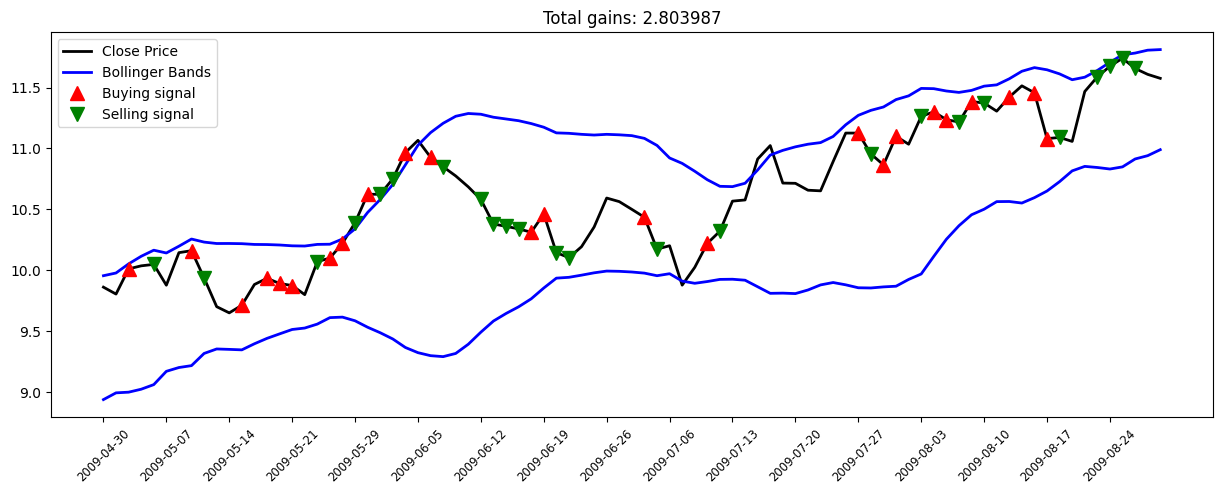

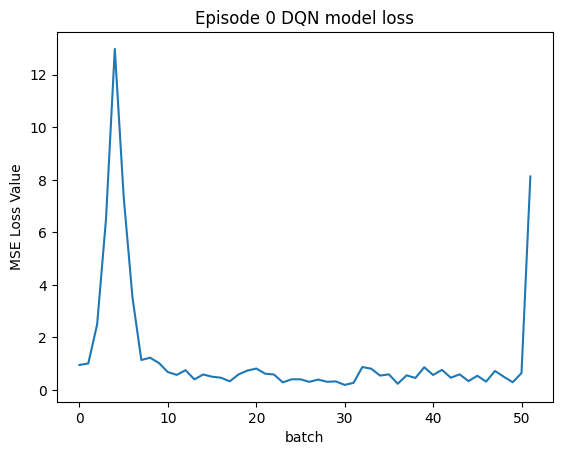

Running episode 1/2:   0%|          | 0/84 [00:00<?, ?it/s]

Episode 1, Time 0: Buy at $9.86
Episode 1, Time 2: Sell at $10.01, Profit: $0.15
Episode 1, Time 5: Buy at $9.88
Episode 1, Time 6: Buy at $10.15
Episode 1, Time 7: Sell at $10.16, Profit: $0.28
Episode 1, Time 8: Buy at $9.94
Episode 1, Time 9: Sell at $9.70, Profit: -$0.44
Episode 1, Time 10: Sell at $9.65, Profit: -$0.29
Episode 1, Time 11: Buy at $9.71
Episode 1, Time 12: Buy at $9.88
Episode 1, Time 14: Sell at $9.89, Profit: $0.18
Episode 1, Time 15: Sell at $9.88, Profit: -$0.01
Episode 1, Time 16: Buy at $9.80
Episode 1, Time 17: Sell at $10.07, Profit: $0.27
Episode 1, Time 20: Buy at $10.39
Episode 1, Time 21: Sell at $10.62, Profit: $0.23
Episode 1, Time 23: Buy at $10.75
Episode 1, Time 24: Buy at $10.97
Episode 1, Time 25: Sell at $11.07, Profit: $0.32
Episode 1, Time 26: Buy at $10.93
Episode 1, Time 27: Sell at $10.85, Profit: -$0.12
Episode 1, Time 28: Buy at $10.77
Episode 1, Time 30: Sell at $10.58, Profit: -$0.35
Episode 1, Time 33: Sell at $10.34, Profit: -$0.43
Epi

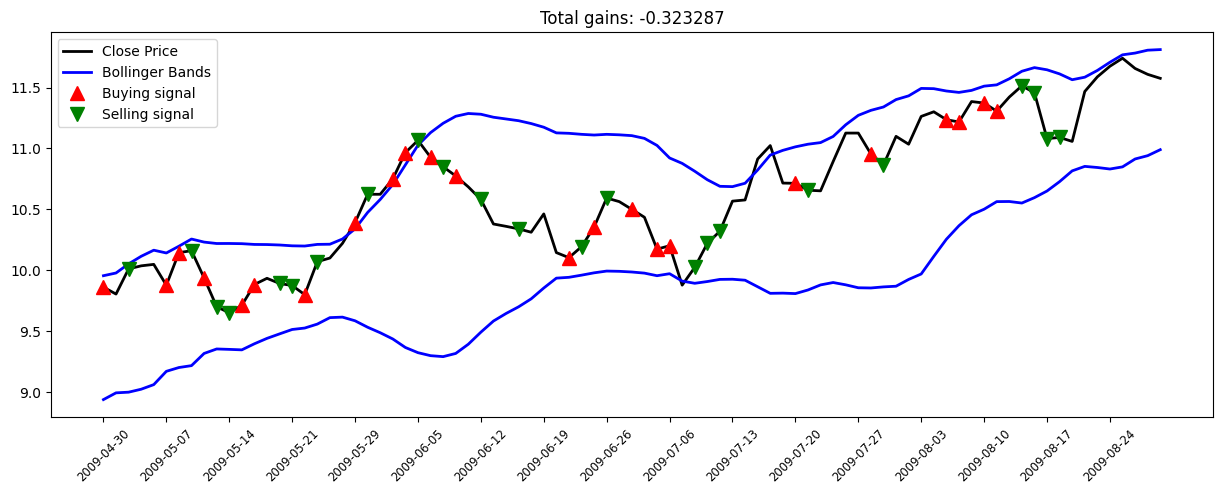

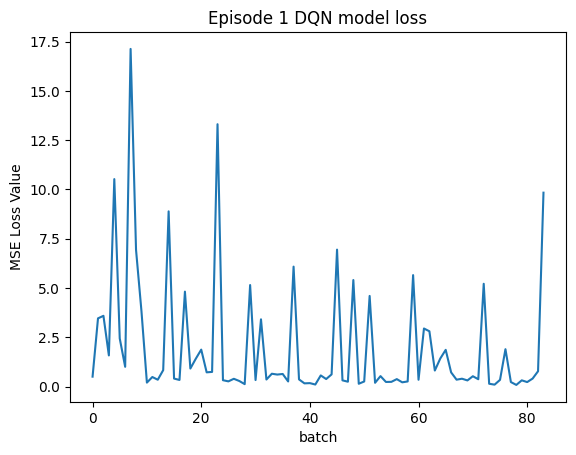

Running episode 2/2:   0%|          | 0/84 [00:00<?, ?it/s]

Episode 2, Time 0: Buy at $9.86
Episode 2, Time 1: Sell at $9.81, Profit: -$0.06
Episode 2, Time 6: Buy at $10.15
Episode 2, Time 7: Buy at $10.16
Episode 2, Time 11: Sell at $9.71, Profit: -$0.43
Episode 2, Time 12: Sell at $9.88, Profit: -$0.28
Episode 2, Time 23: Buy at $10.75
Episode 2, Time 24: Sell at $10.97, Profit: $0.21
Episode 2, Time 26: Buy at $10.93
Episode 2, Time 27: Sell at $10.85, Profit: -$0.08
Episode 2, Time 28: Buy at $10.77
Episode 2, Time 29: Buy at $10.68
Episode 2, Time 30: Sell at $10.58, Profit: -$0.19
Episode 2, Time 31: Buy at $10.38
Episode 2, Time 32: Sell at $10.36, Profit: -$0.32
Episode 2, Time 33: Buy at $10.34
Episode 2, Time 34: Buy at $10.31
Episode 2, Time 35: Buy at $10.46
Episode 2, Time 37: Sell at $10.10, Profit: -$0.28
Episode 2, Time 38: Sell at $10.19, Profit: -$0.15
Episode 2, Time 39: Sell at $10.36, Profit: $0.04
Episode 2, Time 40: Sell at $10.59, Profit: $0.13
Episode 2, Time 45: Buy at $10.20
Episode 2, Time 46: Sell at $9.88, Profit:

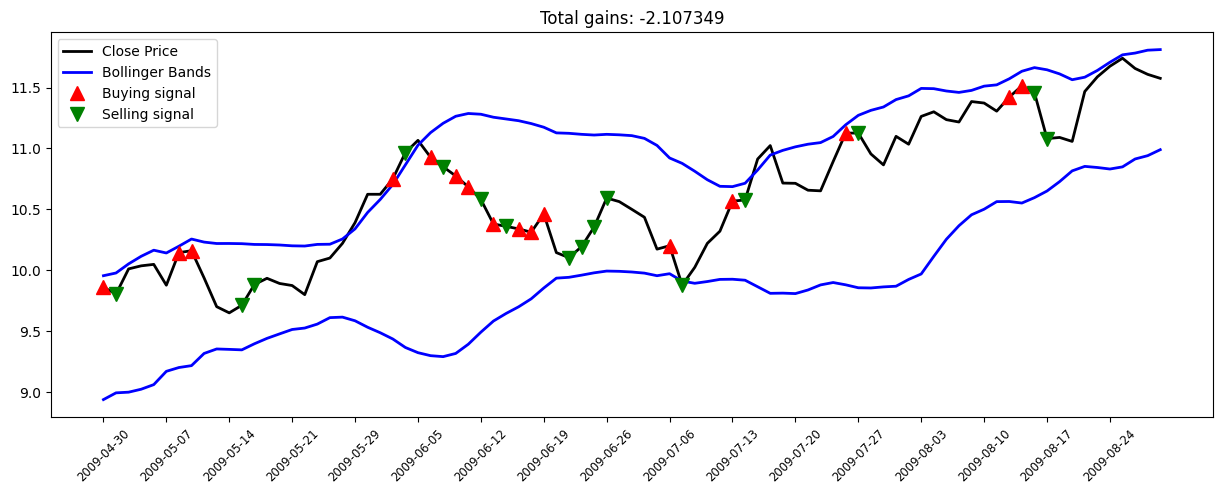

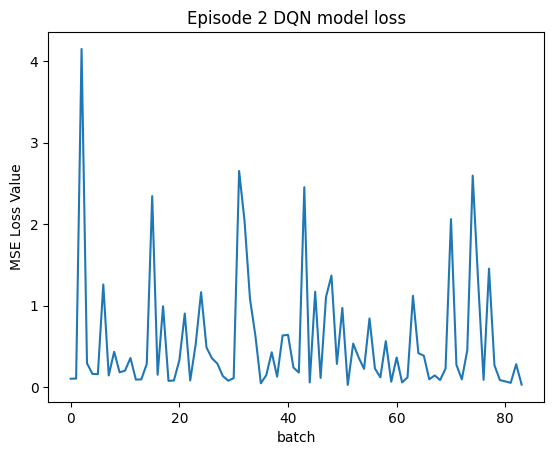

In [33]:
keras.config.disable_traceback_filtering()  # Disable Keras traceback filtering

window_size = 1
num_features = normed_dataset.shape[1]

agent = Agent(window_size=window_size, num_features=num_features)

l = len(X_train) - 1  # Adjusted length to avoid repeating the final state

batch_size = 32
episode_count = 2

normalizer_close = normlist[0]
normalizer_bb_upper = normlist[1]
normalizer_bb_lower = normlist[2]

X_train_true_price = normalizer_close.inverse_transform(X_train[:, 0].reshape(-1, 1)).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, 1].reshape(-1, 1)).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, 2].reshape(-1, 1)).flatten()

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = get_state(X_train, 0, window_size + 1)
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)
        next_state = get_state(X_train, t + 1, window_size + 1)
        reward = 0

        if action == 1:  # Buy
            price = X_train_true_price[t]
            agent.inventory.append(price)
            states_buy.append(t)
            print(f"Episode {e}, Time {t}: Buy at {format_price(price)}")

        elif action == 2 and len(agent.inventory) > 0:  # Sell
            bought_price = agent.inventory.pop(0)
            price = X_train_true_price[t]
            trade_profit = price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit
            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
            states_sell.append(t)
            print(f"Episode {e}, Time {t}: Sell at {format_price(price)}, Profit: {format_price(trade_profit)}")

        done = True if t == l - 1 else False

        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(agent.memory) > batch_size:
            batch_loss = agent.exp_replay(batch_size)
            batch_losses.append(batch_loss)

        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            if batch_losses[num_batches_trained:]:
                print(f'Max Loss: {max(batch_losses[num_batches_trained:])}')
                print(f'Total Loss: {sum(batch_losses[num_batches_trained:])}')
            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower,
                          states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

    if e % 2 == 0:
        agent.model.save(f'model_ep{e}.keras')

### Plot Training Loss

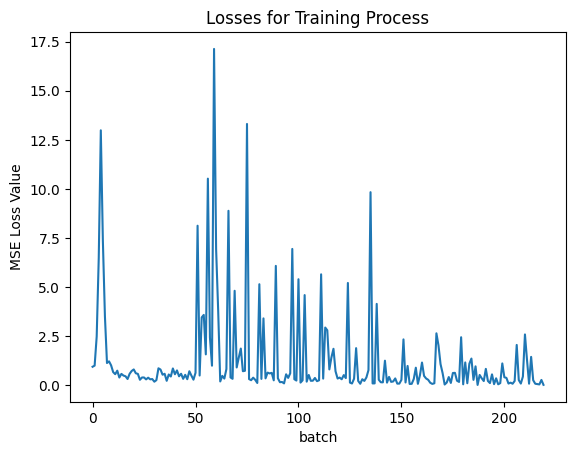

In [34]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, "Losses for Training Process")

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [40]:
l_test = len(X_train) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

state = get_state(X_test, 0, window_size+1)# get the first state of the test dataset

# Inverse transform the test data to get true prices
X_test_true_price = normalizer_close.inverse_transform(X_test[:, 0].reshape(-1, 1)).flatten()
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, 1].reshape(-1, 1)).flatten()
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, 2].reshape(-1, 1)).flatten()

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

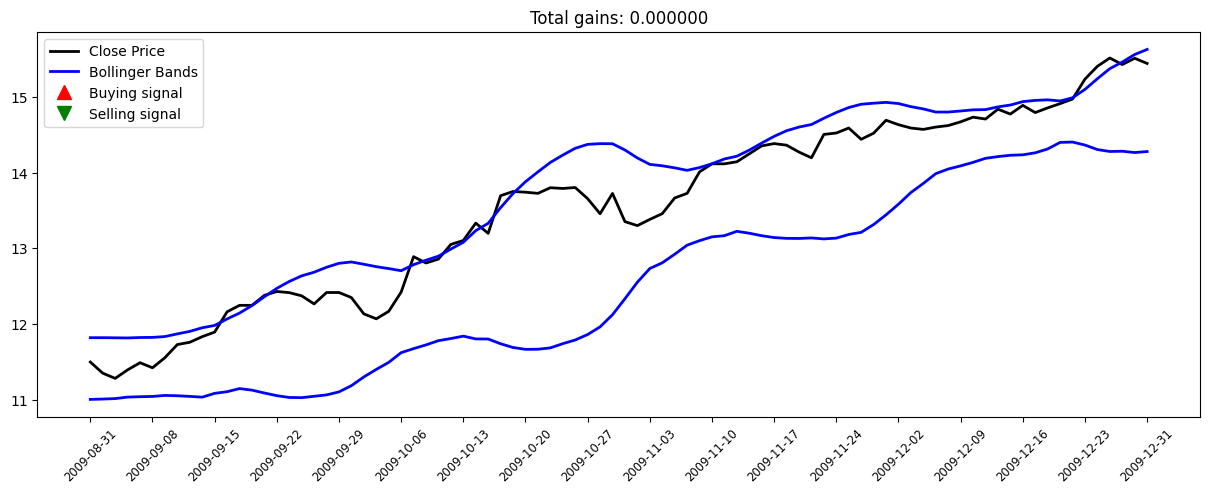

In [41]:
for t in range(l_test-1):
    action = agent.act(state)
    next_state = get_state(X_test, t, window_size+1)
    reward = 0

    if action == 1:  # Buy
        # Inverse transform to get true buy price in dollars
        buy_price = X_test_true_price[t]
        # Append buy price to inventory
        agent.inventory.append(buy_price)
        # Append time step to states_buy_test
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0:  # Sell
        # Get bought price from beginning of inventory
        bought_price = agent.inventory.pop(0)
        # Inverse transform to get true sell price in dollars
        sell_price = X_test_true_price[t]
        # Calculate trade profit
        trade_profit = sell_price - bought_price
        # Reward is max of profit and 0
        reward = max(trade_profit, 0)
        # Update total profit
        total_profit += trade_profit
        # Append time step to states_sell_test
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

    if t == l_test - 1:
        done = True
    else:
        done = False
    # Append to memory so we can re-train on 'live' (test) data later
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')

plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)
